# Week 11 HW: Timeseries

1. What scale of measurement applies to timeseries data? Is timeseries data continuous or discrete? Why?

The appropriate scale of measurement for timeseries data is interval. Timeseries data is continuous if the values have decimals, but is discrete if the values are whole numbers. An example of discrete data is data taken once per week, while an example of continuous data would be a person's age. 

2. What does ARIMA stand for? Break down and explain each piece in the name.

ARIMA stands for auto-regressive integrated moving average. Autoregression is a model that predicts future values based on past values. Integration refers to differencing the raw data to give the timeseries stationarity. Moving averages account for the dependency between an observation and a residual error from a model applied to "lagged" observations, or observations over a set period of time.

3. Using the data in the temperatures/ folder. Write a function that efficiently converts every column to a different temperature scale: one that is more common than Kelvin.

In [1]:
# Dependencies:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from pprint import pprint
import statistics
import math
from scipy import stats
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


temperature_df = pd.read_csv("temperature.csv",parse_dates=True, index_col='datetime')
temperature_df.head()

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,309.100000,NaN,NaN,NaN
2012-10-01 13:00:00,284.630000,282.080000,289.480000,281.800000,291.870000,291.530000,293.410000,296.600000,285.120000,284.610000,...,285.630000,288.220000,285.830000,287.170000,307.590000,305.470000,310.580000,304.4,304.4,303.5
2012-10-01 14:00:00,284.629041,282.083252,289.474993,281.797217,291.868185,291.533501,293.403141,296.608509,285.154558,284.607305,...,285.663208,288.247676,285.834650,287.186092,307.590000,304.310000,310.495769,304.4,304.4,303.5
2012-10-01 15:00:00,284.626998,282.091866,289.460618,281.789833,291.862844,291.543355,293.392177,296.631487,285.233952,284.599918,...,285.756824,288.326940,285.847789,287.231672,307.391513,304.281841,310.411539,304.4,304.4,303.5
2012-10-01 16:00:00,284.624955,282.100481,289.446243,281.782449,291.857503,291.553209,293.381213,296.654466,285.313345,284.592530,...,285.850440,288.406203,285.860929,287.277251,307.145200,304.238015,310.327308,304.4,304.4,303.5


In [3]:
# Conversion to Celsius:
def celsius(city,scale='C'):
    try:
        if scale == 'C':
            city = city - 273.15
        else:
            print("Scale should be Celsius(C)")
    except Exception as e:
        print(e)
    return city

#Creating new df. 
temp_df = pd.DataFrame(index=temperature_df.index)

# iterating through the df to convert to C. 
for col in temperature_df.columns:
    temp_df[col] = celsius(temperature_df[col],scale='C')
    
#Checking to make sure the new df has been converted to C.     
temp_df.head()

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,35.950000,NaN,NaN,NaN
2012-10-01 13:00:00,11.480000,8.930000,16.330000,8.650000,18.720000,18.380000,20.260000,23.450000,11.970000,11.460000,...,12.480000,15.070000,12.680000,14.020000,34.440000,32.320000,37.430000,31.25,31.25,30.35
2012-10-01 14:00:00,11.479041,8.933252,16.324993,8.647217,18.718186,18.383501,20.253141,23.458509,12.004558,11.457306,...,12.513208,15.097676,12.684650,14.036092,34.440000,31.160000,37.345769,31.25,31.25,30.35
2012-10-01 15:00:00,11.476998,8.941867,16.310618,8.639833,18.712845,18.393355,20.242177,23.481487,12.083952,11.449918,...,12.606824,15.176940,12.697789,14.081672,34.241513,31.131841,37.261539,31.25,31.25,30.35
2012-10-01 16:00:00,11.474955,8.950481,16.296243,8.632449,18.707503,18.403209,20.231213,23.504466,12.163345,11.442530,...,12.700441,15.256203,12.710929,14.127251,33.995200,31.088015,37.177308,31.25,31.25,30.35


4. Write a function that efficiently fills in missing values in every column, excluding trailing NANs. That is: if there's temperature data on either side of a timestamp, it should interpolate through it. But if data stopped being collected, your function should leave nans at the end.

In [4]:
# .interpolate() to fill NANs
temp_df_filled = temp_df.interpolate(limit_area='inside')

# Checking numbers of rows to see if fill worked:
print(temp_df_filled.isna().sum().sum())
print(temp_df.isna().sum().sum())


print(temp_df_filled['Montreal'].isna())
print(temp_df['Montreal'].isna())

# Sample city:
temp_df['Montreal']

7955
8030
datetime
2012-10-01 12:00:00     True
2012-10-01 13:00:00    False
2012-10-01 14:00:00    False
2012-10-01 15:00:00    False
2012-10-01 16:00:00    False
                       ...  
2017-11-29 20:00:00    False
2017-11-29 21:00:00    False
2017-11-29 22:00:00    False
2017-11-29 23:00:00    False
2017-11-30 00:00:00    False
Name: Montreal, Length: 45253, dtype: bool
datetime
2012-10-01 12:00:00     True
2012-10-01 13:00:00    False
2012-10-01 14:00:00    False
2012-10-01 15:00:00    False
2012-10-01 16:00:00    False
                       ...  
2017-11-29 20:00:00    False
2017-11-29 21:00:00    False
2017-11-29 22:00:00    False
2017-11-29 23:00:00    False
2017-11-30 00:00:00    False
Name: Montreal, Length: 45253, dtype: bool


datetime
2012-10-01 12:00:00          NaN
2012-10-01 13:00:00    12.680000
2012-10-01 14:00:00    12.684650
2012-10-01 15:00:00    12.697789
2012-10-01 16:00:00    12.710929
                         ...    
2017-11-29 20:00:00     1.980000
2017-11-29 21:00:00     0.980000
2017-11-29 22:00:00     0.330000
2017-11-29 23:00:00    -0.670000
2017-11-30 00:00:00    -1.350000
Name: Montreal, Length: 45253, dtype: float64

5. Find all cities A and B where city A is warmer than city B in the summer, but also colder than city B in the winter, on average.

In [5]:
# get months from datetime
temp_df_filled['month']= pd.DatetimeIndex(temp_df_filled.index).month
temp_df_filled.head()

x=temp_df_filled
summer_months= [5,6,7,8,9]
winter_months= [10,11,12,1,2,3,4]

x[x.month.isin(summer_months)]

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem,month
datetime,,,,,,,,,,,,,,,,,,,,,
2013-05-01 00:00:00,11.40,13.88,27.29,12.83,21.11,19.43,36.07,37.77,25.93,24.19,...,12.60,16.590,15.26,19.350,21.00,23.950,21.850,21.850,19.15,5
2013-05-01 01:00:00,10.96,13.43,27.10,11.98,20.67,17.97,35.69,37.28,24.40,23.32,...,12.04,16.070,13.69,19.350,21.00,21.000,21.850,21.850,19.15,5
2013-05-01 02:00:00,10.29,11.11,25.24,10.13,19.13,16.94,34.74,35.74,22.26,22.14,...,12.03,14.640,12.55,19.350,21.72,23.800,21.850,21.850,19.15,5
2013-05-01 03:00:00,9.47,8.93,23.17,8.44,17.28,15.14,32.39,33.77,19.42,20.60,...,12.01,13.880,11.45,27.250,21.72,23.430,24.950,24.950,28.25,5
2013-05-01 04:00:00,8.43,7.75,19.86,7.40,16.29,14.50,31.74,32.26,18.47,18.77,...,11.81,12.807,10.97,27.250,21.00,19.000,24.950,24.950,28.25,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-09-30 19:00:00,13.77,14.86,19.09,14.99,23.36,23.46,31.20,31.13,19.02,19.28,...,17.00,13.670,12.63,19.383,25.56,29.510,25.933,25.933,25.61,9
2017-09-30 20:00:00,13.80,16.50,21.08,15.99,24.95,24.16,32.20,32.70,20.76,19.64,...,16.36,15.000,12.23,15.161,25.56,29.020,25.861,25.861,25.61,9
2017-09-30 21:00:00,13.41,16.37,22.46,15.89,25.89,24.70,31.99,34.00,20.77,20.57,...,15.60,14.670,12.39,15.161,25.11,28.020,25.861,25.861,25.22,9


In [6]:
#Calculated averages for cities during summer months.
avg_summer = x[x.month.isin(summer_months)].iloc[:,0:36].mean().round(2)

#avg_summer
#Calculated averages for cities during winter months.
avg_winter =x[x.month.isin(winter_months)].iloc[:,0:36].mean().round(2)

print(avg_summer, avg_winter)

Vancouver            16.67
Portland             17.98
San Francisco        18.20
Seattle              16.84
Los Angeles          21.59
San Diego            20.39
Las Vegas            28.69
Phoenix              30.65
Albuquerque          20.54
Denver               18.29
San Antonio          26.89
Dallas               27.02
Houston              27.06
Kansas City          22.81
Minneapolis          19.08
Saint Louis          22.92
Chicago              19.81
Nashville            23.50
Indianapolis         21.17
Atlanta              23.79
Detroit              19.70
Jacksonville         26.34
Charlotte            23.35
Miami                27.69
Pittsburgh           19.75
Toronto              18.37
Philadelphia         21.17
New York             21.22
Montreal             18.12
Boston               19.26
Beersheba            23.89
Tel Aviv District    26.57
Eilat                30.15
Haifa                27.11
Nahariyya            25.48
Jerusalem            25.48
dtype: float64 Vancouver    

In [9]:
#Make a new df with average values and cities
average_df=pd.DataFrame(avg_summer)
average_df.columns=['summer_avg']

average_df['winter_avg']=avg_winter

average_df=average_df.reset_index()
average_df.columns=['city','summer_avg','winter_avg']

average_df

,city,summer_avg,winter_avg
0,Vancouver,16.67,6.52
1,Portland,17.98,7.65
2,San Francisco,18.20,12.76
3,Seattle,16.84,7.45
4,Los Angeles,21.59,15.04
5,San Diego,20.39,14.79
6,Las Vegas,28.69,12.85
7,Phoenix,30.65,16.67
8,Albuquerque,20.54,6.95
9,Denver,18.29,3.82


In [10]:
#Iterated inside the average df and compared which the city temp is greater in summer and for the same city temp 
#is less than in winter and print the results.
cityA=[]
cityB=[]

for i in range(len(average_df['city'])):
    city=average_df.iloc[i,0]
    summer_temp=average_df.iloc[i,1]
    winter_temp=average_df.iloc[i,2]
    for j in range(len(average_df['city'])):
        if city!=average_df.iloc[j,0]:
            if (summer_temp>average_df.iloc[j,1]) & (winter_temp<average_df.iloc[j,2]):
                cityA.append(city)
                cityB.append(average_df.iloc[j,0])
                print(city," avg summer temperature of ",summer_temp," is warmer than ",average_df.iloc[j,0],average_df.iloc[j,1],)
                print(city," avg winter temperature of ",winter_temp," is colder than ",average_df.iloc[j,0],average_df.iloc[j,2])

Las Vegas  avg summer temperature of  28.69  is warmer than  Los Angeles 21.59
Las Vegas  avg winter temperature of  12.85  is colder than  Los Angeles 15.04
Las Vegas  avg summer temperature of  28.69  is warmer than  San Diego 20.39
Las Vegas  avg winter temperature of  12.85  is colder than  San Diego 14.79
Las Vegas  avg summer temperature of  28.69  is warmer than  San Antonio 26.89
Las Vegas  avg winter temperature of  12.85  is colder than  San Antonio 16.36
Las Vegas  avg summer temperature of  28.69  is warmer than  Dallas 27.02
Las Vegas  avg winter temperature of  12.85  is colder than  Dallas 13.9
Las Vegas  avg summer temperature of  28.69  is warmer than  Houston 27.06
Las Vegas  avg winter temperature of  12.85  is colder than  Houston 16.95
Las Vegas  avg summer temperature of  28.69  is warmer than  Jacksonville 26.34
Las Vegas  avg winter temperature of  12.85  is colder than  Jacksonville 17.66
Las Vegas  avg summer temperature of  28.69  is warmer than  Miami 27.69


Detroit  avg summer temperature of  19.7  is warmer than  Vancouver 16.67
Detroit  avg winter temperature of  3.08  is colder than  Vancouver 6.52
Detroit  avg summer temperature of  19.7  is warmer than  Portland 17.98
Detroit  avg winter temperature of  3.08  is colder than  Portland 7.65
Detroit  avg summer temperature of  19.7  is warmer than  San Francisco 18.2
Detroit  avg winter temperature of  3.08  is colder than  San Francisco 12.76
Detroit  avg summer temperature of  19.7  is warmer than  Seattle 16.84
Detroit  avg winter temperature of  3.08  is colder than  Seattle 7.45
Detroit  avg summer temperature of  19.7  is warmer than  Denver 18.29
Detroit  avg winter temperature of  3.08  is colder than  Denver 3.82
Detroit  avg summer temperature of  19.7  is warmer than  Boston 19.26
Detroit  avg winter temperature of  3.08  is colder than  Boston 4.74
Jacksonville  avg summer temperature of  26.34  is warmer than  Nahariyya 25.48
Jacksonville  avg winter temperature of  17.66  

6. For two of the cities you found in question 5 (there are many possible answers), clean up the data via rolling averages and plot a clear visual. Explain how rolling average differs from moving average (MA) model.

Rolling average takes average of the data points in a widow. In the above case a widow of 30 calendar days were selected to calculate average temperature.

Moving average model is used for time series analysis for future prediction. It is used when the output data is linearly dependendt on the past and present values. Because of this MA model assumes equal weights for all data points unlike the rolling average.

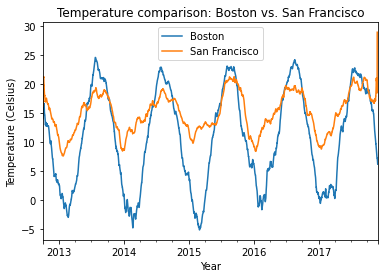

In [11]:
temp_df_filled[["Boston","San Francisco"]].rolling('30D').mean().plot(title="Temperature comparison: Boston vs. San Francisco")
plt.xlabel("Year")
plt.ylabel("Temperature (Celsius)")
plt.show()

7. Perform SARIMA on five cities, iterating through the cities programmatically. Explain your results.
	•	Graph the predicted values 30 days out.

Explanation of results: 

The AIC (Akaike information criterion) is an estimator of out-of-sample prediction error and the AIC scores below are low, indicating a good predictive model.  

In [12]:
# Resampling the data for from hourly to weekly
resampled_df = temp_df_filled.resample('W').mean()

# Five cities:
my_cities = resampled_df.loc[:,['Boston', 'San Francisco', 'Phoenix', 'Dallas', 'Toronto']]
my_cities.head()

,Boston,San Francisco,Phoenix,Dallas,Toronto
datetime,,,,,
2012-10-07,16.653653,19.254145,27.727976,20.638853,14.191592
2012-10-14,9.970714,15.026220,24.593244,18.527798,7.521369
2012-10-21,13.090893,18.237708,24.469315,19.877173,10.485565
2012-10-28,11.531964,13.921310,22.128095,20.378304,11.057708
2012-11-04,11.412946,14.973899,21.392500,16.844345,5.776458


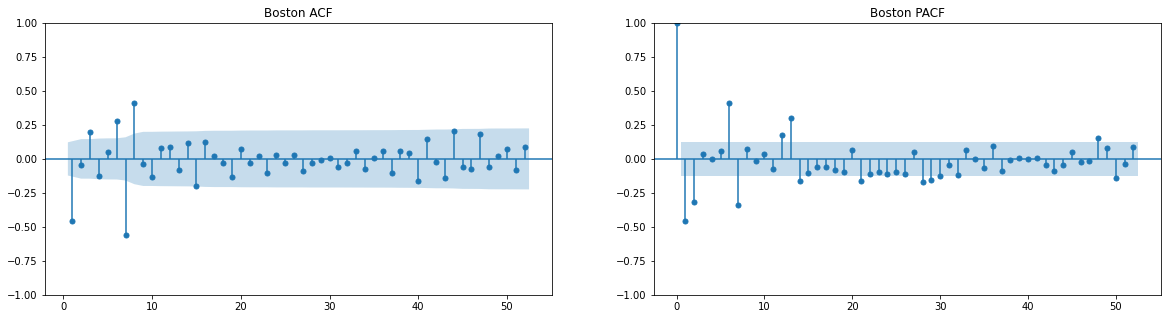

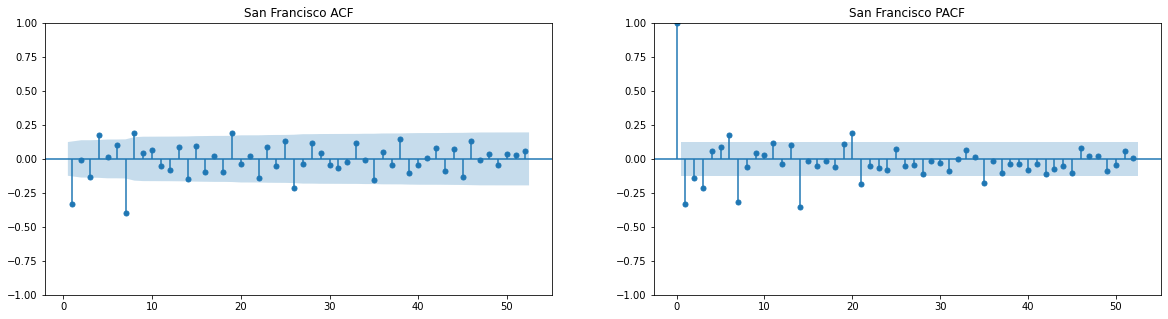

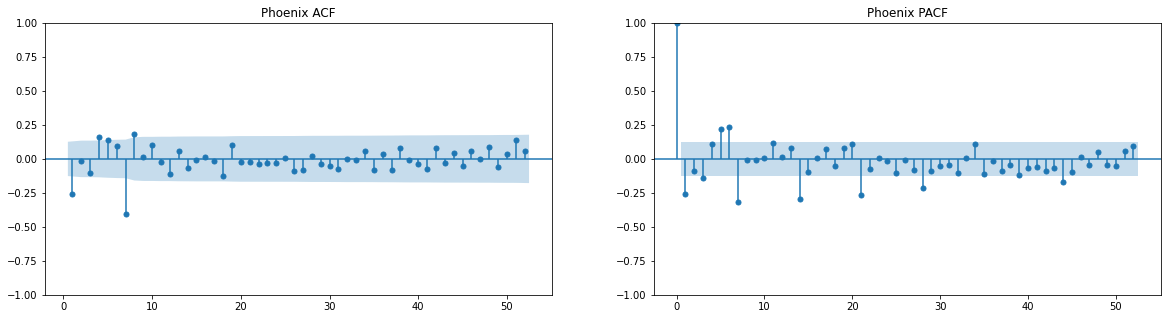

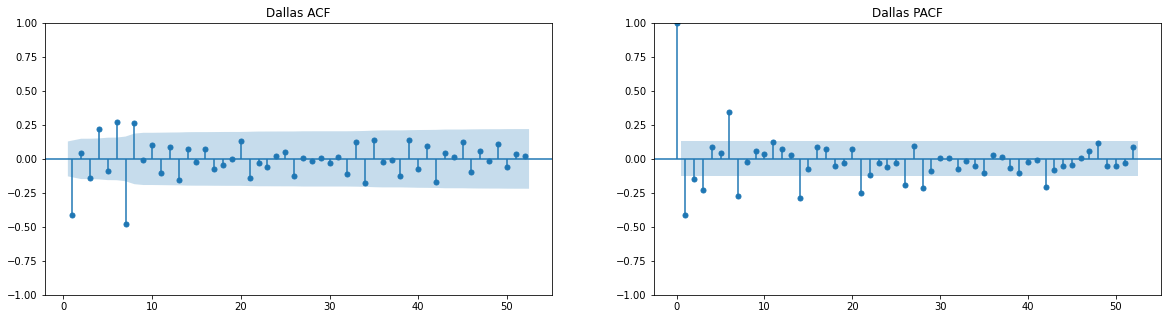

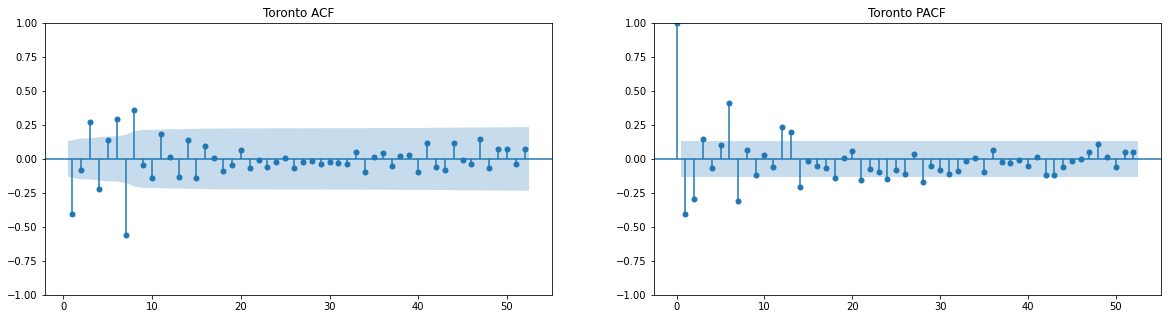

In [13]:
#Ignore warnings:
import warnings
warnings.filterwarnings('ignore')

#create a copy
my_cities_stationary = my_cities.copy(deep=False)

#loop through the dataframe and make it stationary, then plot it:
for i in my_cities:
    
    my_cities_stationary["diff_"+i]=my_cities_stationary[i].diff().diff(7).dropna()
    my_cities_stationary=my_cities_stationary.dropna()
    
    fig, ax = plt.subplots(1,2, figsize=(20,5))
    plot_acf(my_cities_stationary[["diff_"+i]],zero=False,lags=52, ax=ax[0],missing='drop',title=i + " ACF");
    plot_pacf(my_cities_stationary[["diff_"+i]],lags=52, ax=ax[1],method='ywm',title=i + " PACF");

In [14]:
model = pd.Series()

results = pd.Series()

for i in my_cities:
    model[i] = SARIMAX(my_cities_stationary[i],order=(0,1,0), seasonal_order=(2,1,0,52))
    results[i] = model[i].fit(low_memory=True)
    print(results[i].summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20180D+00    |proj g|=  2.90514D-02


 This problem is unconstrained.



At iterate    5    f=  2.19862D+00    |proj g|=  3.98572D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7      9      1     0     0   6.331D-07   2.199D+00
  F =   2.1986185219889949     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                     SARIMAX Results                                      
Dep. Variable:                             Boston   No. Observations:                  225
Model:             SARIMAX(0, 1, 0)x(2, 1, 0, 52)   Log Likelihood                -494.689
Date:                            Sun, 12 Dec 2021   AIC                            995.3

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.76685D+00    |proj g|=  5.87340D-02

At iterate    5    f=  1.76319D+00    |proj g|=  3.27042D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      9      1     0     0   5.463D-06   1.763D+00
  F =   1.7631873560307649     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                     SARIMAX Results                                      
Dep. Variable:                      San F

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.00177D+00    |proj g|=  8.96578D-02

At iterate    5    f=  1.98637D+00    |proj g|=  1.97832D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      8      1     0     0   8.667D-06   1.986D+00
  F =   1.9863745178699956     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                     SARIMAX Results                                      
Dep. Variable:                           

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16685D+00    |proj g|=  6.18697D-02

At iterate    5    f=  2.16118D+00    |proj g|=  1.30186D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7      9      1     0     0   4.050D-06   2.161D+00
  F =   2.1611807888964005     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                     SARIMAX Results                                      
Dep. Variable:                           

 This problem is unconstrained.



At iterate    5    f=  2.17563D+00    |proj g|=  9.29235D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      8      1     0     0   6.029D-06   2.176D+00
  F =   2.1756324193912588     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                     SARIMAX Results                                      
Dep. Variable:                            Toronto   No. Observations:                  225
Model:             SARIMAX(0, 1, 0)x(2, 1, 0, 52)   Log Likelihood                -489.517
Date:                            Sun, 12 Dec 2021   AIC                            985.0

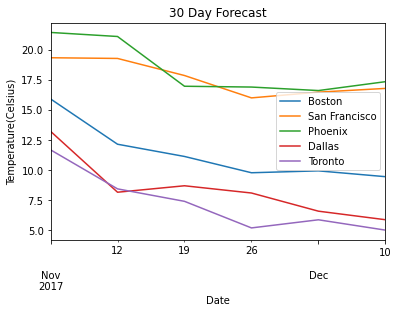

In [15]:
# Graph of 30 da prediction. 

for i in my_cities:
    results[i].forecast(steps=6).plot(legend=True,title="30 Day Forecast".format(city=i), xlabel="Date", ylabel="Temperature(Celsius)")
plt.legend(['Boston', 'San Francisco', 'Phoenix', 'Dallas', 'Toronto'])
plt.show()

8. Explain what you see when you perform results.summary() on the cities in question 7. 

Summary Observations:

- P value should be less than 0.05 in order for SARIMA to be the best model choice.
- The AIC and BIC values are checked to help choose the right values. The model with the lowest AIC value is best. 
- The AR coeff value shows that the mean is reverting in opposite directions.

In [16]:
#Print a summary for each city 
for i in my_cities:
    print("\033[1m Summary for ",i,": \n \033[0m", results[i].summary())

 Summary for  Boston : 
                                       SARIMAX Results                                      
Dep. Variable:                             Boston   No. Observations:                  225
Model:             SARIMAX(0, 1, 0)x(2, 1, 0, 52)   Log Likelihood                -494.689
Date:                            Sun, 12 Dec 2021   AIC                            995.378
Time:                                    23:21:46   BIC                           1004.821
Sample:                                07-14-2013   HQIC                           999.209
                                     - 10-29-2017                                         
Covariance Type:                           approx                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L52      -0.7670      0.098     -7.814      0.000      -0.959      -0.575
ar.S.L104

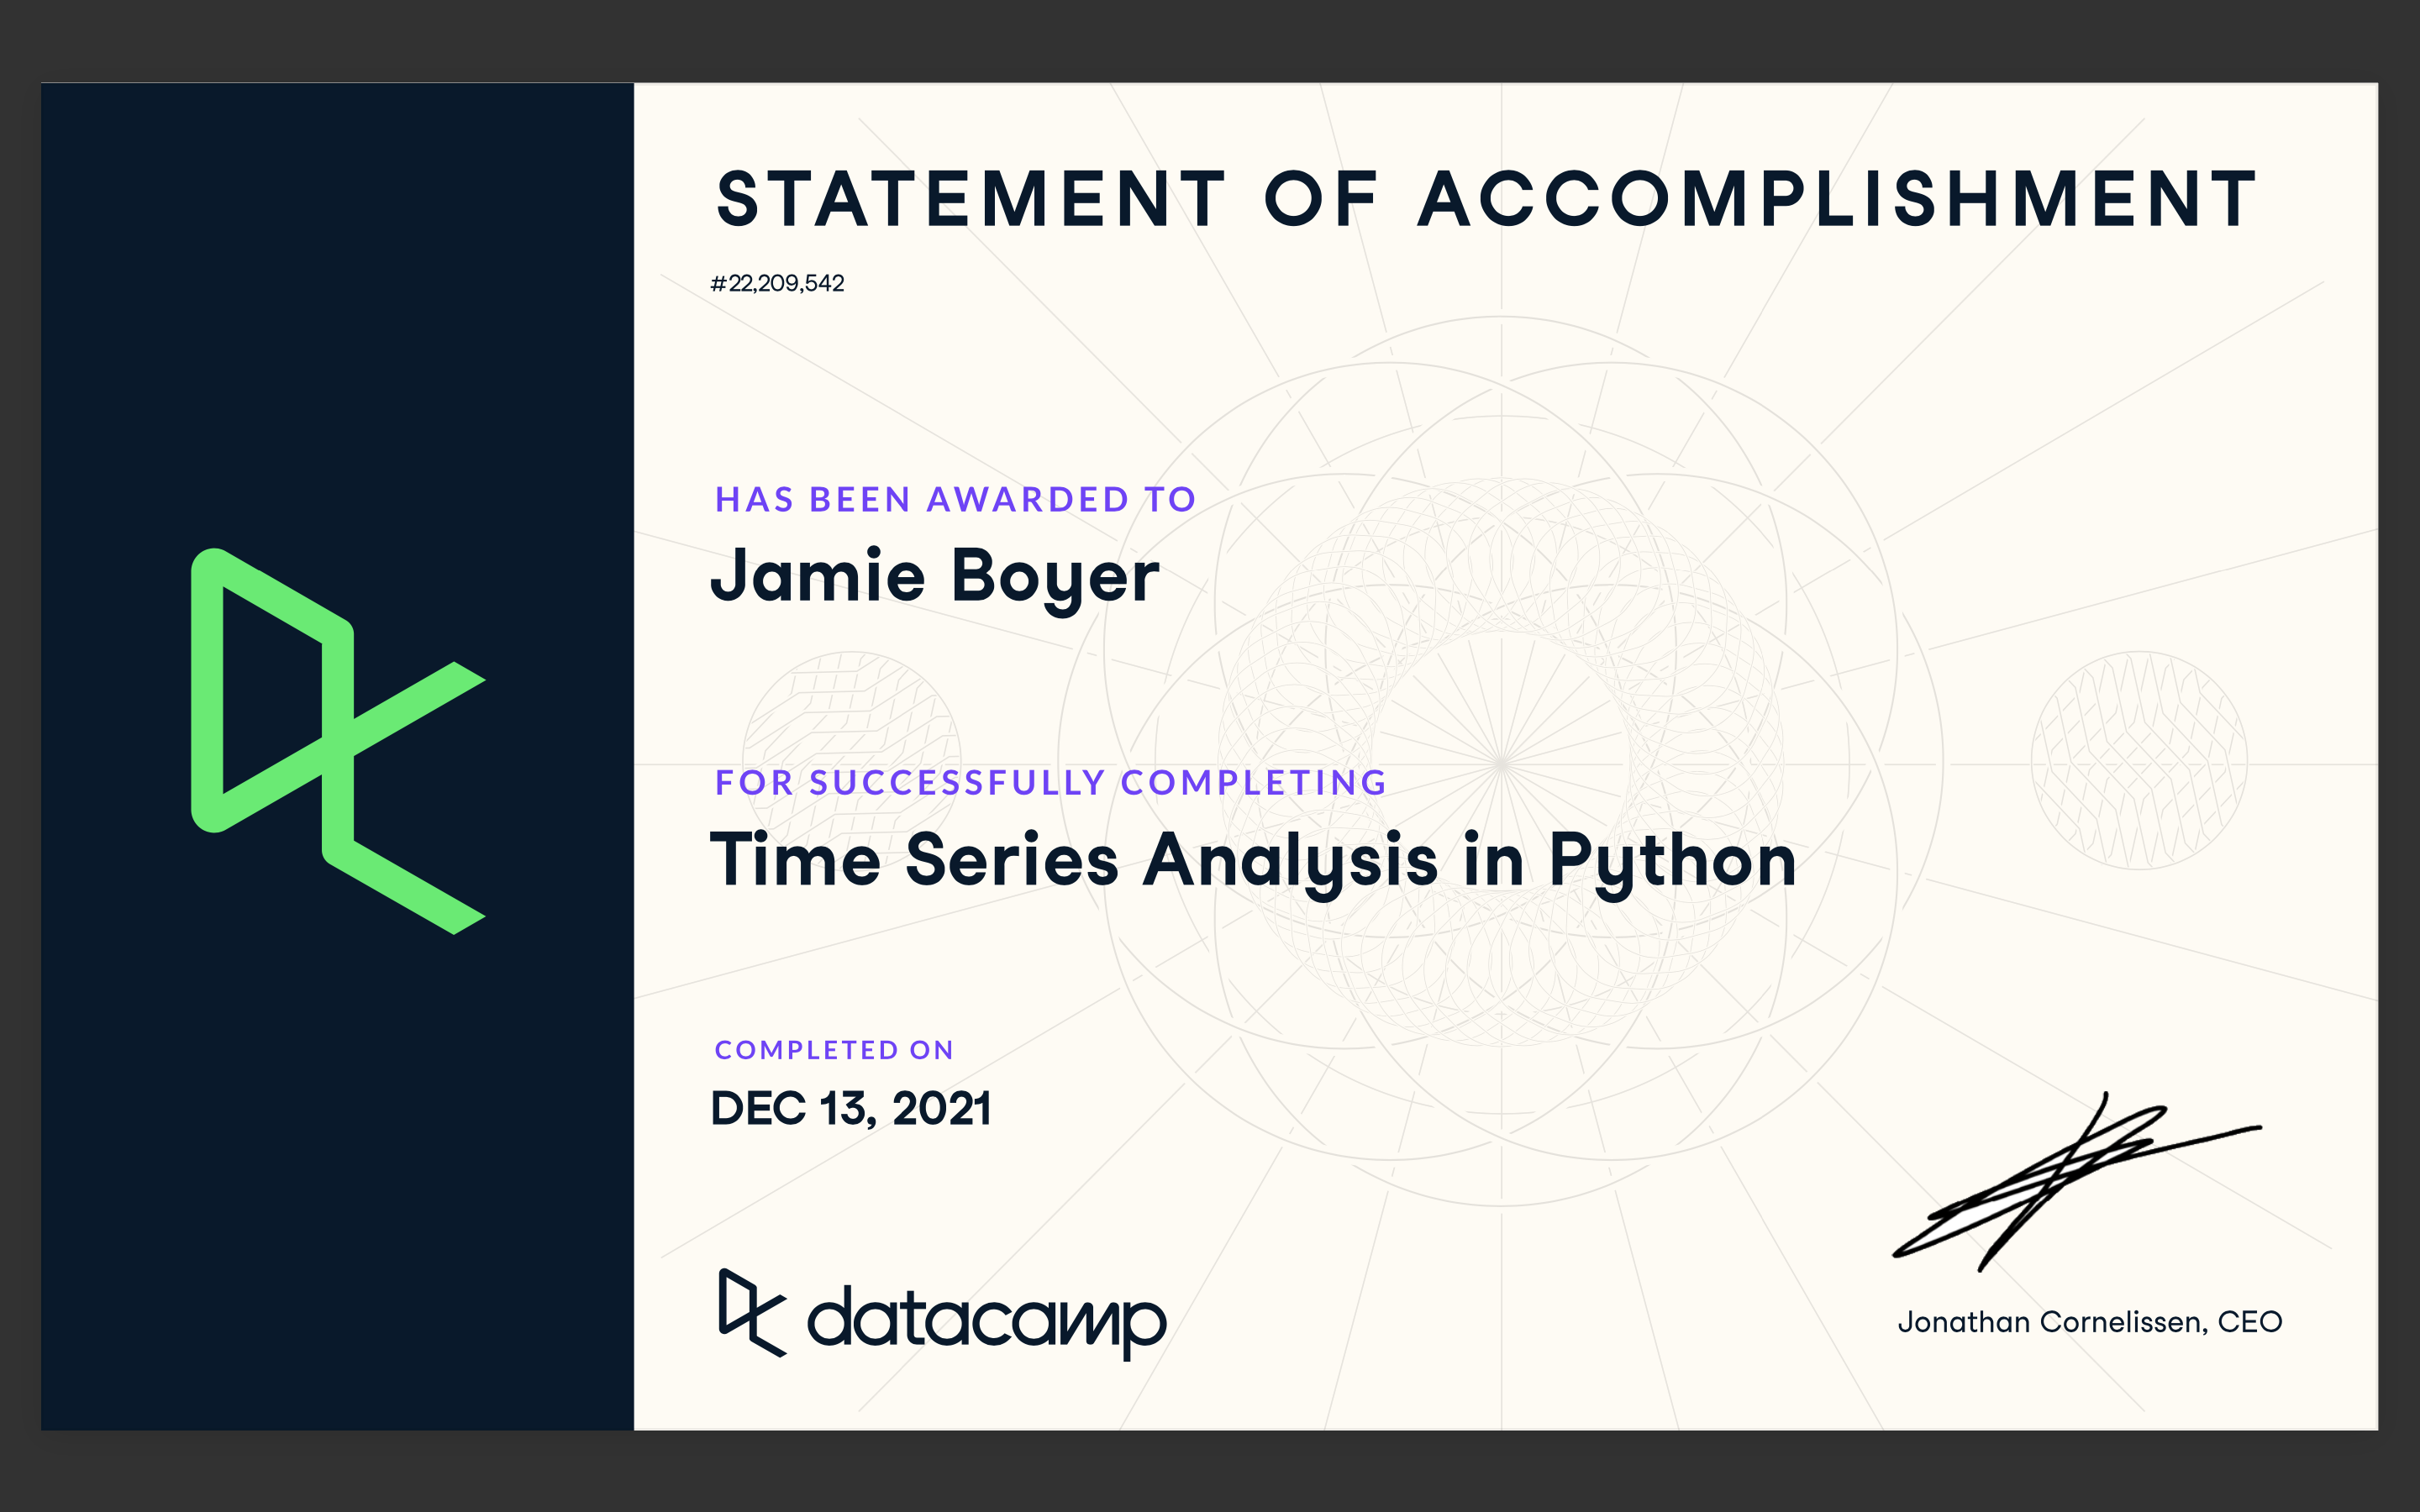